# Praca domowa 3
### Sebastian Deręgowski, grupa 1

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import dalex as dx
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import seaborn as sns

Na początek wczytajmy naszą ramkę danych:

In [3]:
australia = pd.read_csv("https://raw.githubusercontent.com/mini-pw/2021L-WUM/main/Prace_domowe/Praca_domowa3/australia.csv")
australia.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0
1,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0
2,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0
3,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0
4,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0


Wyzdzielmy w naszym zbiorze zmienne objaśniające i zmienną celu, a następnie dokonajmy podziału na zbiór treningowy i testowy:

In [4]:
from sklearn.model_selection import train_test_split

X = australia[australia.columns.values[:-1]]
y = australia[australia.columns.values[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, test_size = 0.3)

W celu uniknięcia powtarzania tego samego kodu, stwórzmy funkcję, która jako argument przyjmie nazwę modelu (wraz z parametrami), a zwróci nam różne miary oceny jego predykcji.

In [5]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def model_analysis(model_name):
    model = model_name
    model.fit(X_train,y_train)
    y_predicted = model.predict(X_test)
    print(f"Precision : {precision_score(y_test, y_predicted)}")
    print(f"Recall : {recall_score(y_test, y_predicted)}")
    print(f"AUC: {roc_auc_score(y_test, y_predicted)}")
    tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
    confusion_sum = tn + fp + fn + tp
    confusion_accuracy = (tn + tp) / confusion_sum
    print(f"Confusion matrix accuracy: {confusion_accuracy}")
    print(pd.DataFrame({"Actual positives": [tp/ confusion_sum, fp/ confusion_sum], 
                        "Actual negatives": [fn/ confusion_sum, tn/ confusion_sum]}, 
                 index = ["Positive predictions", "Negative predictions"]))

Do każdego z trzech modeli, które sprawdzimy, dostroimy jeden z parametrów przy pomocy GridSearchCV.

### RandomForest

Dla tego modelu dostroimy parametr *max_features* określający liczbę cech branych pod uwagę podczas podziału.

In [6]:
parameters = {'max_features':('auto','sqrt','log2')}

In [7]:
gscv = GridSearchCV(RandomForestClassifier(),parameters,n_jobs=-1)
gscv.fit(X_train,y_train)
print(gscv.best_params_)

{'max_features': 'sqrt'}


In [8]:
model_analysis(RandomForestClassifier(max_features='sqrt'))

Precision : 0.7630979498861048
Recall : 0.5345744680851063
AUC: 0.7435898316424316
Confusion matrix accuracy: 0.8597424081295049
                      Actual positives  Actual negatives
Positive predictions          0.118752          0.103391
Negative predictions          0.036866          0.740990


### XGBoostClassifier

Dla tego modelu dostroimy parametr *booster* decydujący o tym, który klasyfikator zostanie użyty. Możliwe wartości tego parametru to *{'gbtree,'gblinear','dart'}*.

In [9]:
parameters = {'booster':('gbtree','gblinear','dart')}

In [10]:
gscv = GridSearchCV(xgb.XGBClassifier(objective = "binary:logistic",  use_label_encoder=False),parameters,n_jobs=-1)
gscv.fit(X_train,y_train)
print(gscv.best_params_)

{'booster': 'gbtree'}


In [11]:
model_analysis(xgb.XGBClassifier(objective = "binary:logistic", booster='gbtree', use_label_encoder=False))

Precision : 0.7462462462462462
Recall : 0.5287234042553192
AUC: 0.7386895161941947
Confusion matrix accuracy: 0.8553704360155973
                      Actual positives  Actual negatives
Positive predictions          0.117452          0.104691
Negative predictions          0.039939          0.737918


### Regresja logistyczna

Dla tego modelu dostroimy parametr *solver* oznaczający algorytm, za pomocą którego dokonuje się optymalizacja. Dostępne algorytmy to: *{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}*. Niektóre algorytmy wymagają ustawienia parametru *verbose* na dodatnią liczbę, z tego powodu ten parametr również dodamy do siatki.

In [12]:
parameters = {'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),'verbose':(0,1)}

In [13]:
gscv = GridSearchCV(LogisticRegression(max_iter=1000),parameters,n_jobs=-1)
gscv.fit(X_train,y_train)
print(gscv.best_params_)

{'solver': 'newton-cg', 'verbose': 0}


In [14]:
model_analysis(LogisticRegression(solver='newton-cg',max_iter=1000,verbose=0))

Precision : 0.7281518624641834
Recall : 0.5406914893617021
AUC: 0.7415215004153186
Confusion matrix accuracy: 0.8531253692544015
                      Actual positives  Actual negatives
Positive predictions          0.120111          0.102032
Negative predictions          0.044842          0.733014


### Kroswalidacja i podsumowanie

Dość nieoczekiwanie wszystkie trzy modele miały bardzo zbliżoną skuteczność, co szczególnie dziwi w przypadku XGBoosta, który zazwyczaj radzi sobie dużo lepiej od prostej regresji logistycznej. Być może zatem to wybrany zbiór testowy okazał się być na tyle specyficzny, że zrównał ze sobą wszystkie 3 modele. W celu większej rzetelności wyników przeprowadźmy kroswalidacje wszystkich trzech modeli. Za parametr *scoring* przyjmiemy *f1*, który jest miarą łączącą *precision* i *recall*, dobrze sprawdzającą się dla binarnych klasyfikacji.

Model RandomForestClassifier(max_features='sqrt'): 
 Średnia wyniku: 0.5965726819644881 
 Odchylenie standardowe: 0.0473676324153271 

Model XGBClassifier(use_label_encoder=False): 
 Średnia wyniku: 0.5977038113136395 
 Odchylenie standardowe: 0.04726318970124113 

Model LogisticRegression(max_iter=1000, solver='newton-cg'): 
 Średnia wyniku: 0.6095906678725057 
 Odchylenie standardowe: 0.0407918946214133 



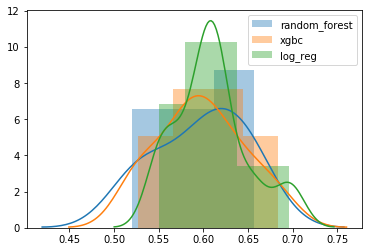

In [15]:
from sklearn.model_selection import cross_val_score

models = [RandomForestClassifier(max_features='sqrt'),
          xgb.XGBClassifier(objective = "binary:logistic", booster='gbtree', use_label_encoder=False),
         LogisticRegression(solver='newton-cg',max_iter=1000,verbose=0),]

scores = []

for i in range(len(models)):
    scores.append(cross_val_score(models[i], X,y, cv=10,scoring='f1'))
    print(f"Model {models[i]}: \n Średnia wyniku: {np.mean(scores[i])} \n Odchylenie standardowe: {np.std(scores[i])} \n")

sns.distplot(scores[0], label="random_forest")
sns.distplot(scores[1], label="xgbc")
sns.distplot(scores[2], label="log_reg")

plt.legend()
plt.show()

Kroswalidacja potwierdza, że wszystkie trzy modele mają bardzo zbliżoną skuteczność. Z tego powodu trudno jest wybrać najlepszy z nich. Minimalnie najlepiej spisał się RandomForest, ale wyniki są na tyle równorzędne, że chyba nie ma sensu określać go mianem "zwycięzcy".